<a href="https://colab.research.google.com/github/vpagonis/EURADOS-2023/blob/main/Code3_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code 3.1 Fitting TL data with the Kitis-Vlachos equation (KV-TL)

This file contains  a simple example of fitting experimenta TL data using the  Kitis-Vlachos equation (KV-TL).

The original KV-TL equation for CGCD is: 

\begin{equation}
I(T)=A\,\frac{\exp[-E/\left(k_{B}T\right)]}{W[e^{z}]+W[e^{z}]^{2}}
\end{equation}

\begin{equation}
z=\frac{1}{c}-\ln(c)+s'\,\frac{\:k\:T^{2}}{\beta\:E}\,\exp\left[-\frac{E}{k\,T}\right]\;\left(1-\frac{2kT}{E}\right)
\end{equation}

The four independent fitting parameters in these CGCD equations are $E, c, s'$ and $A$. Note that the new frequency parameter $s'=1/\left(1-R\right) (in s^{-1})$  represents an effective frequency factor for the TL process. 
By fitting the data we can obtain the value of $E$ (in eV), the value of the effective frequency parameter $s' ( s^{-1})$, the amplitude $A$
 (in the same units as the TL intensity of the experimental data) and the dimensionless quantity $c$.

The analysis is once more for the Reference glow curve #1 from the GLOCANIN project, which was analyzed in the previous Code 3.1. 

When using the KV-TL as a fitting function, it is important to constrain the values of the fitting parameters, otherwise the least squares fit can produce physically unreasonable values. 

In this example, we constrain the values of $A$ in the interval $(10^{8},10^{15})$, the energy $E$ (eV) in the interval (0.9,1.3), the constant $c$ in the broad interval $(10^{-4},10^{4})$ and the frequency factor $s'$ in the interval $(10^{8},10^{14}) (s^{-1})$. The starting values of the fitting parameters in the algorithm are $A=10^{10}, c=10, E=1$ eV and $s'=2\times10^{9} s^{-1}$. The code uses the function `wrightomega()` which was discussed in the previous chapter.

The results show that the activation energy $E=\left(1.176\pm10^{-5}\right)\:eV$, which is within $\sim4%$ of the expected value of $E=1.182\:eV$. The FOM=0.5 %, indicating a very good fit to this simulated TL data. The rest of the best fit parameters are $s'=6.9\times10^{10} s^{-1} , A=3.1\times10^{8}$ and $c=9998.2$. The residuals $y_{i}^{expt}-y_{i}^{fit}$ of the best fit, are of the order of 3% of the experimental TL intensity.

Once the value of E has been determined, we can evaluate the original trap frequency factor $s$ (which is different from $s'$), by using the heating rate equation for first order kinetics, which was discussed in the previous chapter:

\begin{equation}
s=\frac{\beta\:E}{k_{B}T_{m}^{2}}\exp\left(\frac{E}{k_{B}T_{m}}\right)
\end{equation}

Substituting the best fit parameters $E=1.176\:eV, T_{m}= 496 K$ and heating rate $\beta$=1 K/s we find $s=1.5\times10^{10} s^{-1}$, close to the original value $s=8.05\times10^{10} s^{-1}$ used in the paper by Bos et al. [#Bos1993d]. 

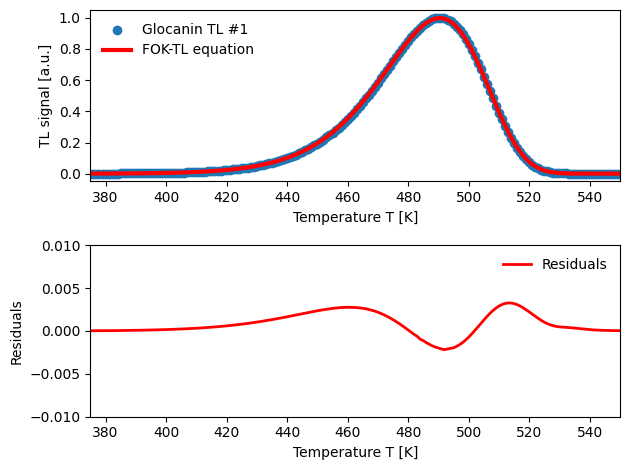

FOM= 0.5  %
+------------+------------+------------+------------+
|  Field 1   |  Field 2   |  Field 3   |  Field 4   |
+------------+------------+------------+------------+
|     A      |     dA     | s' (s^-1)  | ds' (s^-1) |
|    3.1E+08 |    7.4E-05 |    6.9E+10 |    3.2E-07 |
|            |            |            |            |
|   E (eV)   |   dE(eV)   |     c      |     dc     |
|   1.176    |   1e-05    |   9998.2   |    2.3     |
+------------+------------+------------+------------+


In [9]:
# Deconvolution of single TL peak with Lambert-OTOR equation
from scipy import optimize
import numpy as np
from prettytable import PrettyTable 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
#warnings.filterwarnings("ignore")
from scipy.special import wrightomega

# read data file from GitHub
url='https://github.com/vpagonis/EURADOS-2023/raw/main/glocanin1.TXT'

response=requests.get(url)
a=response.text
b=np.array(list(map(float,a.strip("[]").split())))
data=b.reshape(-1,2)

x_data,y_data = data[:, 0], data[:, 1] 
y_data=y_data/max(y_data)

kB, beta=  8.617e-5,  1

# function for evaluating the KV-TL equation
def W_func(T,A,sprime, E, c): 
   expint=kB*(T**2.0)/(beta*E)*np.exp(-E/(kB*T))*(1-2*kB*T/E)
   zTL=(1/c)-np.log(c)+(sprime*expint)
   lam=wrightomega(zTL)
   return A*np.exp(-E/(kB*T))/(lam+lam**2)       

# inis = starting values (A, s, E,c) for the fit 
inis=([1e10,2e9,1.,10])

# bounds = lower and upper bounds for (A, s, E,c)
# find optimal parameters 

# params = the best fit values for the parameters 
# cov = the covariance of the best fit parameters 
params, cov=optimize.curve_fit(W_func,x_data,y_data,p0=inis,\
        bounds=((1e8,1e8,.9,1e-4),(1e15,1e14,1.3,1e4)))

# plot the data and the best fit
plt.subplot(2,1, 1);  
plt.scatter(x_data, y_data, label='Glocanin TL #1');
plt.plot(x_data, W_func(x_data, *params),
c='r',linewidth=3, label='FOK-TL equation'); 
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('TL signal [a.u.]');
plt.xlabel(r'Temperature T [K]');
plt.xlim(375,550);

# plot the residuals
plt.subplot(2,1, 2); 
plt.plot(x_data,W_func(x_data, *params)-\
y_data,c='r',linewidth=2,label='Residuals');
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('Residuals');
plt.xlabel(r'Temperature T [K]');
plt.xlim(375,550);
plt.ylim(-0.01,.01);
plt.tight_layout()
plt.show()

# Find the Figure of Merit FOM
res=W_func(x_data, *params)-y_data
FOM=round(100*np.sum(abs(res))/np.sum(y_data),1)

# Create Table for the best fit parameters
A=format(params[0],"10.1E")
sprime=format(params[1],"10.1E")
E=round(params[2],3)
c=round(params[3],1)
dA = format(np.sqrt(cov[0][0]),"10.1E")
dsprime = format(np.sqrt(cov[1][1]),"10.1E")
dE = round(np.sqrt(cov[2][2]),5)
dc = round(np.sqrt(cov[3][3]),1)
myTable = PrettyTable()
myTable.add_row([ "A","dA", "s' (s^-1)","ds' (s^-1)"])
myTable.add_row([A,dA,sprime,dsprime])
myTable.add_row([" "]*4)
myTable.add_row(["E (eV)","dE(eV)","c","dc"])
myTable.add_row([E,dE,c,dc])

#print the FOM and the Table of best fit parameters
print("FOM=",FOM," %")
print(myTable)
